<a href="https://colab.research.google.com/github/Programmatical-tea/colab_test/blob/main/CNN/Audio_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
model_path = ".\\models"

In [2]:
import os,sys

import numpy as np

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

import pandas as pd
from tqdm import trange
import librosa
import tqdm
from sklearn.model_selection import KFold

from datetime import datetime

In [17]:
n_class = 10
n_fft = 1024
m = 345 # most of them are length 345 when hop_length = win_length//4 = n_fft//4
m = 173 #remove later!!
BATCH_SIZE = 32
img_height, img_width = int(n_fft/2+1),m
sample_rate = 22050
batch_size = 1
load_grayscale = True
channels = 1 if load_grayscale else 3
input_shape = (img_height, img_width, channels)

In [60]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


# For running on hosted server

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/UrbanSound8K/

/content/drive/.shortcut-targets-by-id/12NzKaJnvfXDKUZJa1ZBIUuyCxMlKI9WG/UrbanSound8K


# For running on local server (전재원)

In [4]:
cd Desktop/한과영/R&E/Urbansound/

C:\Users\USER\Desktop\한과영\R&E\Urbansound


# Processing the Audio files

In [5]:
cd ..

C:\Users\USER\Desktop\한과영\R&E


In [6]:
cd Urbansound8K/

C:\Users\USER\Desktop\한과영\R&E\Urbansound8K


In [7]:
data = pd.read_csv("metadata/UrbanSound8K.csv")
n_data = data.shape[0]
data.head() # 상단만 보여줌 

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


Process as stft

In [ ]:
n_fft = 1024

def process_all():
    stft_processed = np.zeros((n_data,2), dtype=np.ndarray)
    for i in trange(n_data):
        filepath = os.path.join("audio", f'fold{data["fold"][i]}', data["slice_file_name"][i])
        time_pressure_array, _ = librosa.load(filepath, res_type='kaiser_fast')
        stft_processed[i][0] = abs(librosa.stft(time_pressure_array, n_fft = 1024)) # n_fft를 늘릴수록 frequency resolution은 높아지고 time resolution은 낮아짐
        stft_processed[i][1] = data["classID"][i]
    return stft_processed

stft_processed = process_all()

Process as Mel_spectogram ( stft -> spectogram(using abs) -> mel_scale -> 

In [ ]:
n_fft = 1024

def process_all():
    stft_processed = np.zeros((n_data,2), dtype=np.ndarray)
    for i in trange(n_data):
        filepath = os.path.join("audio", f'fold{data["fold"][i]}', data["slice_file_name"][i])
        time_pressure_array, _ = librosa.load(filepath, res_type='kaiser_fast')
        stft_processed[i][0] = librosa.power_to_db(abs(librosa.feature.melspectrogram(time_pressure_array, n_fft = 1024, hop_length=n_fft//4, win_length=n_fft))) # n_fft를 늘릴수록 frequency resolution은 높아지고 time resolution은 낮아짐
        stft_processed[i][1] = data["classID"][i]
    return stft_processed

stft_processed = process_all()

Process as the phase of stft

In [8]:
n_fft = 1024

def process_all():
    stft_processed = np.zeros((n_data,2), dtype=np.ndarray)
    for i in trange(n_data):
        filepath = os.path.join("audio", f'fold{data["fold"][i]}', data["slice_file_name"][i])
        time_pressure_array, _ = librosa.load(filepath, res_type='kaiser_fast')
        stft_processed[i][0] = np.angle(librosa.stft(time_pressure_array, n_fft = 1024)) # n_fft를 늘릴수록 frequency resolution은 높아지고 time resolution은 낮아짐
        stft_processed[i][1] = data["classID"][i]
    return stft_processed

stft_processed = process_all()

100%|██████████████████████████████████████████████████████████████████████████████| 8732/8732 [05:47<00:00, 25.11it/s]


Load right after processing

In [9]:
data = pd.DataFrame(stft_processed)
data.columns = ['feature', 'label']
K = data.feature.tolist()
l = data.label.tolist()

In [10]:
shapes = []
for i in K:
  shapes.append(i.shape[1])
shapes.sort()

In [11]:
print(shapes[len(shapes)//5])

345


In [13]:
m = shapes[len(shapes)//5] #345 when using stft...?? 
X = []
y = []
cnt = 0
for i,k in enumerate(K):
  if m == k.shape[1]:
    X.append(k)
    y.append(l[i])
    cnt += 1
    
X = np.array(X)
y = np.array(y)
X = np.reshape(X,(cnt,n_fft//2+1,m,1)) # (cnt,n_fft//2+1,m,1) when using stft..  the mel scale somehow changes the height to 128
#np.save("X",X,allow_pickle=True)
#np.save("y",y,allow_pickle=True)

In [ ]:
print(X.shape,y.shape)

# Converting to image, then using tf.dataset

In [16]:
cd ..

C:\Users\USER\Desktop\한과영\R&E


In [17]:
cd Urbansound/

C:\Users\USER\Desktop\한과영\R&E\Urbansound


In [18]:
np.save("data/y_phs",y,allow_pickle=True)

Save as an image

In [ ]:
from PIL import Image
for i in trange(X.shape[0]):
  assert X[i].shape == (n_fft/2 + 1, m, 1)
  pil_img = tf.keras.preprocessing.image.array_to_img(X[i])
  pil_img = pil_img.save("data_img/class_"+str(y[i])+"/idX_img_"+str(i)+".jpg")

Save the numpy array itself

In [21]:
for i in trange(X.shape[0]):
  assert X[i].shape == (n_fft//2+1, m, 1) # (n_fft/2 + 1, m, 1) when using stft... the mel scale somehow changes the height to 128... the range of human hearing?
  np.save("data_phs/class_"+str(y[i])+"/X_"+str(i)+".npy",X[i],allow_pickle=True)

100%|█████████████████████████████████████████████████████████████████████████████| 7326/7326 [00:21<00:00, 340.45it/s]


# Finer control

In [18]:
import pathlib
data_dir = pathlib.Path('data_mel')
print(data_dir)

data_mel


In [19]:
image_count = len(list(data_dir.glob('*/*.npy')))
print(image_count)

7327


In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir)+'/*/*.npy', shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
print(list_ds.take(5))

<TakeDataset shapes: (), types: tf.string>


check

In [21]:
for f in list_ds.take(1):
  print(type(f))
  print(f.numpy())
  break

<class 'tensorflow.python.framework.ops.EagerTensor'>
b'data_mel\\class_2\\X_4611.npy'


In [22]:
labels = np.load("data/y_mel.npy",allow_pickle=True)

In [23]:
class_names = []
for i in labels:
  a = 'class_' + str(i)
  if a not in class_names:
    class_names.append(a)
class_names.sort()
print(class_names)
labels = []

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']


Initializing train_ds, val_ds

In [24]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
for i in train_ds.take(1):
  print(i)
val_ds = list_ds.take(val_size)

tf.Tensor(b'data_mel\\class_9\\X_4070.npy', shape=(), dtype=string)


In [25]:
print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(val_ds).numpy())

tf.Tensor(5862, shape=(), dtype=int64)
1465


In [26]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  #return tf.cast(one_hot,dtype=tf.int64)
  return tf.argmax(one_hot)

Check

In [27]:
for file_path in train_ds:
  print(file_path)
  print(get_label(file_path))
  break

tf.Tensor(b'data_mel\\class_9\\X_4070.npy', shape=(), dtype=string)
tf.Tensor(9, shape=(), dtype=int64)


In [28]:
def process_path(file_path):
  label = get_label(file_path)
  spec = np.load(file_path,allow_pickle=True)
  spec = np.concatenate([spec] * channels, axis = 2) # when channels is 3, turns it into a rgb image (that is black/white)
  spec = spec.reshape((128,m,channels)) #(int(n_fft/2+1),m,1) when using stft... mel scale somehow changes the height to 128
  spec = tf.convert_to_tensor(spec)
  return spec, label

In [29]:
for file_path in train_ds:
  print(process_path(file_path.numpy()))
  break

(<tf.Tensor: shape=(128, 173, 1), dtype=float32, numpy=
array([[[-13.656918],
        [-19.047546],
        [-21.887962],
        ...,
        [-21.156569],
        [-22.921066],
        [-17.346571]],

       [[-10.244009],
        [-18.595795],
        [-22.569118],
        ...,
        [-23.192759],
        [-29.953081],
        [-29.113157]],

       [[ -8.770942],
        [-17.044561],
        [-18.917356],
        ...,
        [-19.748602],
        [-28.351952],
        [-30.509037]],

       ...,

       [[-56.09758 ],
        [-54.417416],
        [-58.347145],
        ...,
        [-64.3451  ],
        [-65.81372 ],
        [-67.814606]],

       [[-60.61149 ],
        [-62.09787 ],
        [-64.94994 ],
        ...,
        [-69.81801 ],
        [-69.81801 ],
        [-69.81801 ]],

       [[-65.500496],
        [-69.81801 ],
        [-69.81801 ],
        ...,
        [-69.81801 ],
        [-69.81801 ],
        [-69.81801 ]]], dtype=float32)>, <tf.Tensor: shape=(), dtype=int6

In [30]:
print(train_ds)

<SkipDataset shapes: (), types: tf.string>


In [31]:
AUTOTUNE = tf.data.AUTOTUNE

def process_path_numpy(input):
  y = tf.numpy_function(process_path, [input], [tf.float32,tf.int64])
  return y

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
#train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(process_path_numpy, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path_numpy, num_parallel_calls=AUTOTUNE)

In [32]:
print(train_ds)

<ParallelMapDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int64)>


Check

In [33]:
#for image, label in train_ds.take(1):
  #print("Image shape: ", image)
  #print("Label: ", label)

In [35]:
max_forscale = 0
for image, _ in train_ds:
  temp = image.numpy().reshape( 128 * m * channels, ).max(axis = 0) 
  if max_forscale < temp:
    max_forscale = temp
print(max_forscale)

35.181602


In [37]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

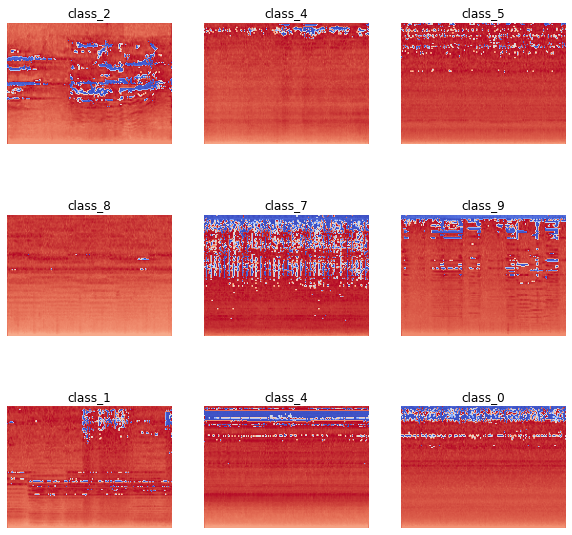

In [38]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"),cmap='coolwarm')
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

Check

In [39]:
'''import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")'''

'import matplotlib.pyplot as plt\n\nimage_batch, label_batch = next(iter(train_ds))\n\nplt.figure(figsize=(10, 10))\nfor i in range(9):\n  ax = plt.subplot(3, 3, i + 1)\n  plt.imshow(image_batch[i].numpy().astype("uint8"))\n  label = label_batch[i]\n  plt.title(class_names[label])\n  plt.axis("off")'

# Preparing Models

In [40]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

def get_model_VGG():
  n_classes = 10

  # this could also be the output a different Keras model or layer
  base_model = VGG16(weights='imagenet', 
                                  include_top=False, 
                                  input_shape=(img_height,img_width,3))
  # base_model.trainable = False

  # Freeze four convolution blocks
  for layer in base_model.layers[:15]:
      layer.trainable = False

  x = base_model.output
  x = tf.keras.layers.Flatten()(x) # Flatten dimensions to for use in FC layers
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x) # Dropout layer to reduce overfitting
  x = tf.keras.layers.Dense(256, activation='relu')(x)
  x = tf.keras.layers.Dense(n_classes, activation='softmax')(x) # Softmax for multiclass
  model = keras.Model(inputs=base_model.input, outputs=x)

In [41]:
def get_model1():
  num_classes = 10

  model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./max_forscale,input_shape = (128,m,channels)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),#(int(n_fft/2+1),m,1).... again, the mel scale changes the height to 128
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes)
  ])

  return model

In [42]:
def get_model3(): # Using Xception
    xception = tf.keras.applications.Xception(include_top=False, weights="imagenet",
                                              input_shape=input_shape, classes=n_class, pooling='avg')
    model = tf.keras.Sequential([
        xception,                  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(n_class, activation='softmax'),
    ])
    return model

In [43]:
def get_model4(): 
    resnet101 = tf.keras.applications.ResNet101(include_top=False, weights="imagenet",
                                                input_shape=input_shape, classes=n_class, pooling='avg')
    model = tf.keras.Sequential([
        resnet101,
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_class, activation='softmax')
    ])
    return model

# Compile & Run

In [44]:
model = get_model1()

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['sparse_categorical_accuracy'])

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 173, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 171, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 171, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 83, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 83, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 41, 32)        0

In [46]:
checkpoint_filepath = os.path.join(model_path, datetime.now().strftime("%y-%m-%d_%H-%M-%S")+".hdf5") # 저장할 위치
#checkpoint_filepath = '.\\models\\21-07-03_13-25-25.hdf5'
#model.load_weights(checkpoint_filepath)
print('checkpoint_filepath ==', checkpoint_filepath)

checkpoint_filepath == .\models\21-07-07_12-30-33.hdf5


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,               
    save_weights_only=False,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True,                        # monitor가 가장 최적일 때만 저장
    save_freq='epoch',                          # 매 epoch마다 저장
    verbose=1)

with tf.device('/cpu:0'):
  model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size = BATCH_SIZE,
    epochs=100,
    callbacks = [model_checkpoint_callback]
  )

Epoch 1/100
184/184 [==============================] - 81s 440ms/step - loss: 0.0902 - sparse_categorical_accuracy: 0.9754 - val_loss: 0.5479 - val_sparse_categorical_accuracy: 0.8833

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.88328, saving model to .\models\21-07-07_12-30-33.hdf5
Epoch 2/100
184/184 [==============================] - 86s 466ms/step - loss: 0.1144 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.5264 - val_sparse_categorical_accuracy: 0.8997

Epoch 00002: val_sparse_categorical_accuracy improved from 0.88328 to 0.89966, saving model to .\models\21-07-07_12-30-33.hdf5
Epoch 3/100
184/184 [==============================] - 78s 426ms/step - loss: 0.0908 - sparse_categorical_accuracy: 0.9727 - val_loss: 0.5368 - val_sparse_categorical_accuracy: 0.8771

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.89966
Epoch 4/100
184/184 [==============================] - 82s 446ms/step - loss: 0.1184 - sparse_categorical_accuracy: 0.96